In [13]:
import sys
import pickle
import nltk
from nltk.stem import PorterStemmer
import torch.nn.functional as F
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
nltk.download('punkt')
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
sys.path.insert(0, '..')
from nltk.tokenize import word_tokenize
ps = PorterStemmer()
from collections import Counter
import math

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gxb18167\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
with open('EEG_Text_Pairs.pkl', 'rb') as file:
    EEG_word_level_embeddings = pickle.load(file)
    train_data = pickle.load(file)

In [3]:
with open('Target_Pred_Strings.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
with open("EEG_Sentences.pkl", 'rb') as f:
    Sentences = pickle.load(f)

In [5]:
target_string_list = data['Target_String']

In [6]:
predicted_string_list = data['Predicted_String']

In [7]:
def get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False):
    Correct_Predictions = {}
    Incorrect_Predictions = {}
    counter_list = []

    train_string = " ".join(train_data)
    train_string_tokenized = word_tokenize(train_string)

    if stemming == True:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(ps.stem(w))
    else:
        train_string_tokenized_stemmed = []
        for w in train_string_tokenized:
            train_string_tokenized_stemmed.append(w)



    for i in range(len(target_string_list)):
        target_string = target_string_list[i]
        predicted_string = predicted_string_list[i]

        predicted_string = predicted_string[0:len(target_string)]

        target_tokenized = word_tokenize(target_string)

        #print(target_tokenized)
        predicted_tokenized = word_tokenize(predicted_string)

        if stemming == True:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(ps.stem(w))
                counter_list.append(ps.stem(w))
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(ps.stem(w))
        else:
            target_tokenized_stemmed = []
            predicted_tokenized_stemmed = []
            for w in target_tokenized:
                target_tokenized_stemmed.append(w)
                counter_list.append(w)
            for w in predicted_tokenized:
                predicted_tokenized_stemmed.append(w)

        if strict == False:
            for word in target_tokenized_stemmed:
                if word in predicted_tokenized_stemmed:
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1
        else:
            min_length = min(len(predicted_tokenized_stemmed), len(target_tokenized_stemmed))
            for i in range(min_length):
                if target_tokenized_stemmed[i] == predicted_tokenized_stemmed[i]:
                    word = target_tokenized_stemmed[i]
                    if word in Correct_Predictions:
                        Correct_Predictions[word] += 1
                    else:
                        Correct_Predictions[word] = 1
                else:
                    word = target_tokenized_stemmed[i]
                    if word in Incorrect_Predictions:
                        Incorrect_Predictions[word] += 1
                    else:
                        Incorrect_Predictions[word] = 1



    target_word_counter = Counter(counter_list)
    print(len(target_word_counter))
    word_frequency = Counter(train_string_tokenized_stemmed)
    print(len(word_frequency))

    common_keys = set(target_word_counter.keys()) & set(word_frequency.keys())
    word_frequency = {k: word_frequency[k] for k in common_keys}



    return Correct_Predictions, Incorrect_Predictions, word_frequency


In [14]:
import re


def calculate_tf(sentences):
    term_frequencies = []

    for sentence in sentences:
        # Preprocess the sentence: convert to lowercase and remove non-alphanumeric characters
        preprocessed_sentence = re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower())

        # Tokenize the sentence into words
        words = preprocessed_sentence.split()

        # Calculate term frequency using Counter
        term_frequency = Counter(words)

        # Normalize term frequency by dividing by the total number of terms in the sentence
        total_terms = len(words)
        normalized_tf = {term: frequency / total_terms for term, frequency in term_frequency.items()}

        term_frequencies.append(normalized_tf)

    return term_frequencies

In [15]:
def calculate_idf(sentences):
    preprocessed_sentences = [re.sub(r"[^a-zA-Z0-9\s]", "", sentence.lower()).split() for sentence in sentences]
    unique_terms = set([term for words in preprocessed_sentences for term in words])
    doc_frequencies = Counter()
    for term in unique_terms:
        for words in preprocessed_sentences:
            if term in words:
                doc_frequencies[term] += 1
    total_documents = len(sentences)
    idf_results = {term: math.log(total_documents / (1 + doc_frequency)) for term, doc_frequency in doc_frequencies.items()}
    return idf_results

In [16]:
Correct_Predictions, Incorrect_Predictions, word_frequency = get_word_classifcation_count(target_string_list, predicted_string_list, train_data, stemming=True, strict=False)

873
4027


In [17]:
idf = calculate_idf(Sentences)

In [18]:
Accuracy = {}

for key, value in Correct_Predictions.items():
    Correct_Predictions_word = Correct_Predictions[key]
    if key in Incorrect_Predictions:
        Incorrect_Predictions_word = Incorrect_Predictions[key]



        Accuracy[key] = Correct_Predictions_word/(Correct_Predictions_word + Incorrect_Predictions_word)



In [19]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')

stop_words_accuracy = {}
stop_word_removal_Accuracy = {}
for key, value in Accuracy.items():
    if key not in sw_nltk:
        stop_word_removal_Accuracy[key] = Accuracy[key]
    else:
        stop_words_accuracy[key] = Accuracy[key]

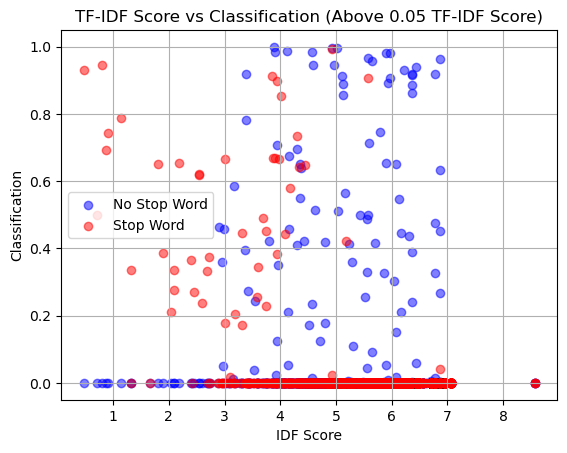

In [20]:
import matplotlib.pyplot as plt
idf_threshold = 0.05  # Adjust as needed

# Filter words based on TF-IDF score threshold
filtered_words = [word for word, idf in idf.items() if idf > idf_threshold]
filtered_tfidf_scores = [idf[word] for word in filtered_words]
stop_word_removal_Accuracy = [stop_word_removal_Accuracy.get(word, 0) for word in filtered_words]
stop_words_accuracy = [stop_words_accuracy.get(word, 0) for word in filtered_words]

# Create figure and axes
fig, ax = plt.subplots()

# Plot correct predictions in blue
ax.scatter(filtered_tfidf_scores, stop_word_removal_Accuracy, color='blue', alpha=0.5, label='No Stop Word')

# Plot incorrect predictions in red
ax.scatter(filtered_tfidf_scores, stop_words_accuracy, color='red', alpha=0.5, label='Stop Word')

# Set labels and title
ax.set_xlabel('IDF Score')
ax.set_ylabel('Classification')
plt.title('TF-IDF Score vs Classification (Above {} TF-IDF Score)'.format(idf_threshold))

# Customize the plot
plt.legend()
plt.grid(True)
plt.show()